<a href="https://colab.research.google.com/github/Raahim58/Neural-networks/blob/main/06_makemore_part5_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. Building Makemore from scratch (Part5: Building a WaveNet)

* Makemore makes more of the things you give it.
* makemore takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an autoregressive character-level language model, with a wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble.
* it is basically a bigram character-level language model

**Resources:**

* makemore github repo: https://github.com/karpathy/makemore/tree/master

* tutorial lecture 6 (makemore part 5) code: https://www.youtube.com/watch?v=t3YJ5hKiMQ0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6

* MLP model based on 2003 paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

* WaveNet 2016 from DeepMind https://arxiv.org/abs/1609.03499

* makemore pre defined code: https://github.com/karpathy/makemore/blob/master/makemore.py

* link to youtube lecture 5: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part5_cnn1.ipynb

* whole lecture series code: https://github.com/karpathy/nn-zero-to-hero

## 0. Getting setup + intro



* our model up till now taking 3 characters as input and predicting the next character in the sequence:

  <img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/MLP.png" height = 300 width = 500>

* we now want to take more characters as input in a sequence not just 3, and in addition to that we don't want to feed them in just a single hidden layer because that squashes too much information too quickly instead we would like to make a deeper model that progressively fuses this information to make its guess about the next character in the sequence.
* as we make the architecture more complex, we're going to arrive at a WaveNet.
* WaveNet is this paper published by DeepLine in 2026 and it is also a language model, but it tries to predict audio sequence instead of character or word level sequences. Fundamentally though, the setup is identical:
  * it is auto aggressive
  * it tries to predict the next character in the sequence
  * the architecture actually takes this interesting hierarchial approach to predict the next character in the sequence with a tree like structure
* most of the setup code is part of part 3
  * doing imports
  * reading our dataset of words
  * processing their set of words into individual examples and none of the data generation code has changed
  * we have 182,000 ish examples of 3 characters trying to predict the 4th one
  * we started developing layer modules in part 3 which are like class linear and we're doing this because we want to think of these modules as building blocks that we can sort of stack up into neural networks and we can feed data between these layers and stack them up in a sort of graph
  * we also developed these layers to have API's and signatures very similar to those found in PyTorch
  * `Linear` does a matrix multiply in the forward pass of this module
  * `BatchNorm` is a layer we look at in the previous lecture. A few crazy things about it:
    * it has running mean and variances that are trained outside of backpropogation. They are trained using exponential moving average inside the `call` layer when we call the `forward` pass.
    * there's a training flag because the behaviour of batchNorm is different during training time and evaluation time, so we have to be careful that batchNorm is in its correct state
    * batchNorm couples the statistics or the activations across the examples in the batch so normally we thought of the batch as just an efficiency thing but now we are coupling the computation across the batch elements and it's done for controlling the activation statistics as seen in the previous lectures
    * we have to wait for the mean and variance to settle and to actually reach as steady rate. Basically, there's state in this layer and state is harmful usually.
  * for reproducibility we will now be using `torch.manual_seed()` as it is more efficient
  * the weights are scaled down in the linear layers so that we are not confidently wrong at initialization
  * 12,000 parameters
  * optimization is identical




In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://github.com/karpathy/makemore/raw/master/names.txt

--2024-08-28 18:16:21--  https://github.com/karpathy/makemore/raw/master/names.txt
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/karpathy/makemore/master/names.txt [following]
--2024-08-28 18:16:21--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-08-28 18:16:21 (9.16 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [8]:
# copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [9]:
torch.manual_seed(42); # seed rng for reproducibility


In [10]:
# original network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [11]:

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


values achived here:
  * 0/ 200000: 3.2966
  * 10000/ 200000: 2.2322
  * 20000/ 200000: 2.4111
  * 30000/ 200000: 2.1004
  * 40000/ 200000: 2.3157
  * 50000/ 200000: 2.2104
  * 60000/ 200000: 1.9653
  * 70000/ 200000: 1.9767
  * 80000/ 200000: 2.6738
  * 90000/ 200000: 2.0837
  * 100000/ 200000: 2.2730
  * 110000/ 200000: 1.7491
  * 120000/ 200000: 2.2891
  * 130000/ 200000: 2.3443
  * 140000/ 200000: 2.1731
  * 150000/ 200000: 1.8246
  * 150000/ 200000: 1.8246
  * 150000/ 200000: 1.8246
  * 160000/ 200000: 1.7614
  * 170000/ 200000: 2.2419
  * 180000/ 200000: 2.0803
  * 190000/ 200000: 2.1326

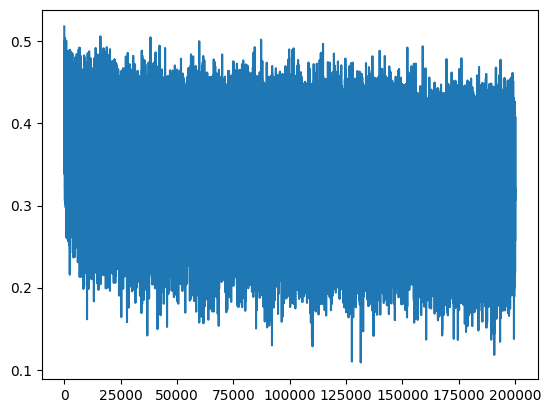

In [12]:
plt.plot(lossi)

In [13]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
  layer.training = False

In [14]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


loss achieved here:
* train 2.0583250522613525
* val 2.1065292358398438

In [15]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all 0s

    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1, block_size, n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors

        for layer in layers:
            x = layer(x)

        logits = x
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word


damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


## 1. Fixing the learning rate plot

* lossi = python list of floats
* we need to average the `lossi` values to get a more thorough representative value along the way
  * we will create a `torch.tensor` out of the list of floats and we will them as whatever it is but we're going to stretch it out into rows of 1000 consecutive elements
  * the shapes of this becomes [200, 1000] and each row is 1000 consecutive elements in this list. That's very helpful as it can do the mean along the rows and the shapes of this will be 200 -> taking the mean on every row
    * this is the learing rate decay and as it goes down, at one point the lr decay subtracted a ton of energy out of the system and allowed us to settle into sort of the local minimum in this optimization


In [16]:
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

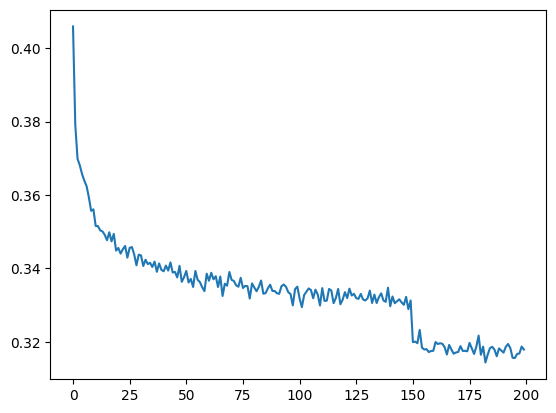

In [17]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [18]:
torch.arange(10).view(2, 5) # 1D array being viewed as a 2D array

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

## 2. Pytorchifying our code: layers, containers, `torch.nn`

* we've organized a few layers inside `layers` but we have the embedding table `C` outside. In addition to that, the viewing operation is also outside of layers so let's create layers for them and we can just add them to our list
* in particular the 2 things we need is that we have the embedding table and we are indexing at the integers inside the batch Xb inside the tensor Xb so that's an embedding table lookup just done with indexing.
  * then we have the `view` operation that just rearranges the character embeddings and structures them into a row and effectively that prints out the concatenation operation -> no memory is being copied, we're just re-representing how we view that tensor
* let's create modules for both (these both exist in pytorch as well but we need it for very specific operations with limited parameters so we don't take the pytorch modules rather create our own):
  * embedding operation
    * X = Xb: tensor of integers specifying the identities of these characters at the input, so now these characters can now directly feed into the first layer and it should just work
  * flattening operation
* right now we're saving all of our layers inside a naked list, we can instead introduce the concept of containers existent in pytorch
  * these containers are ways of organizing lists or dicts and so on
  * particularly `sequential` maintains a list of layers and is a module class in pytorch, it passes through all the layers sequentially exactly as we do it ourselves so we write our own `Sequential` class:
    * we pass in a list of `layers` which we keep in it, and then given any input in a forward pass we just call the layers sequentially and return the results
    * in terms of the parameters it's all the parameters of child modules
    * for the forward pass in the optimization loop we just call the input data which are the integers inside Xb
    * for sampling our model we just want to call the model onto the context and outcome logits, these logits go into `softmax` and then get the `probs`
    * we try to pass a single example in the batchNorm in the training mode, you're going to end up estimating the variance using the input and the variance of a single number is not a number, because it is a measure of a spread
    * we get a result of the `loss` but it's just the wrong result because it's using the sample statistics of the batch whereas we want to use the running mean and the running variance inside the batchNorm
    * we need to properly maintain the state of what is in training and eval mode occordingly
    * our sampling of the model is gibberish because we just initialized the model only

In [19]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [20]:
torch.manual_seed(42); # for reproducibility

In [21]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


results here:  
  * 0/ 200000: 3.2966
  * 10000/ 200000: 2.2322
  * 20000/ 200000: 2.4111
  * 30000/ 200000: 2.1004
  * 40000/ 200000: 2.3157
  * 50000/ 200000: 2.2104
  * 60000/ 200000: 1.9653
  * 70000/ 200000: 1.9767
  * 80000/ 200000: 2.6738
  * 90000/ 200000: 2.0837
  * 100000/ 200000: 2.2730
  * 110000/ 200000: 1.7491
  * 120000/ 200000: 2.2891
  * 130000/ 200000: 2.3443
  * 140000/ 200000: 2.1731
  * 150000/ 200000: 1.8246
  * 160000/ 200000: 1.7614
  * 170000/ 200000: 2.2419
  * 180000/ 200000: 2.0803
  * 190000/ 200000: 2.1326

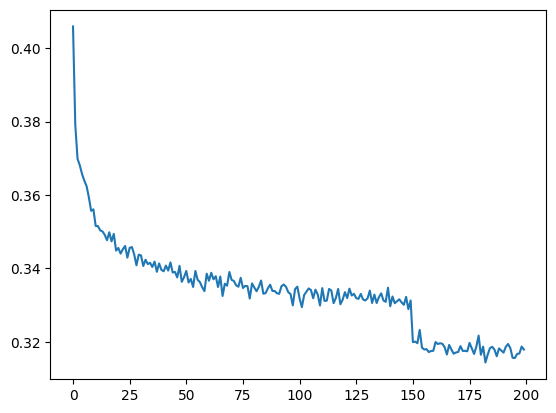

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [24]:
# put layers into eval model (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [25]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065292358398438


results:
* train 2.0583250522613525
* val 2.1065292358398438

In [26]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all 0s

    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))  # (1, block_size)
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

damiara.
alyzah.
fard.
azalee.
sayah.
ayvi.
reino.
sophemuellani.
ciaub.
alith.
sira.
liza.
jah.
grancealynna.
jamaur.
ben.
quan.
torie.
coria.
cer.


## 3. WaveNet

### 3.1 Overview of WaveNet



* our `train` and `val` loss are quite similar so we have the notion that we are not overfitting too much and we can make further progress in our performance by scaling up the size of our neural network and making everything bigger and deeper
* the problem with our older model is that we don't have a naieve way of making this bigger in a productive way, we could of course use our building blocks and materials to  introduce additional layers to make the network deeper but it is still the case that we are crushing all the characters into a single layer all the way at the beginning.
  * even if we make this a bigger layer and add neurons it's still kind of like silly to squash all that information so fast in a single step
  * what we would like to do instead is that we would like our model to look a lot more like this in the WaveNet case

    <img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/wavenet.png" height = 300 width = 300>
    
    * when we're to make a prediction of the next character in the sequence, it is a function of the previous characters that feed in but not all of these characters are not just crushed to a single layer slowly so in particular we take two characters and we fuse them into like a bigram representation and we do that for all the characters consecutively, and then we take the bigrams and we fuse them into four character level chunks and then we fuse that again. So we implement this into like tree-like hierarchial manner so we fuse the information from the previous context slowly into the network as it gets deeper so this is the kind of architecture we want to implement
    * in the WaveNet case, it is a visualization of a stack of dilated causal convolutional layers -> to make the implementation fast through progressive fusion.
      * we want to make the network deeper and at each level we want to fuse only 2 consecutive elements: 2 characters, then 2 bigrams, then 2 four grams

### 3.2 running baseline on code on `block_size` = 8

* we're crushing way too much information way too fast so it doesn't make sense hence we will implement the WaveNet in the next section
* we see

In [27]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [28]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [29]:
# same module as last time
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [30]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [31]:
torch.manual_seed(42);

In [32]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3015
  10000/ 200000: 2.0786
  20000/ 200000: 2.0664
  30000/ 200000: 2.0302
  40000/ 200000: 1.9507
  50000/ 200000: 2.3314
  60000/ 200000: 2.0863
  70000/ 200000: 2.5462
  80000/ 200000: 1.8006
  90000/ 200000: 2.0433
 100000/ 200000: 2.0739
 110000/ 200000: 2.0573
 120000/ 200000: 2.1711
 130000/ 200000: 2.0571
 140000/ 200000: 1.9843
 150000/ 200000: 2.2379
 160000/ 200000: 1.8067
 170000/ 200000: 2.3033
 180000/ 200000: 2.0616
 190000/ 200000: 2.2136


results here:
  * 0/ 200000: 3.3001
  * 10000/ 200000: 2.1169
  * 20000/ 200000: 2.1788
  * 30000/ 200000: 2.0672
  * 40000/ 200000: 1.9115
  * 50000/ 200000: 2.2206
  * 60000/ 200000: 2.1615
  * 70000/ 200000: 2.4519
  * 80000/ 200000: 1.6731
  * 90000/ 200000: 2.1636
  * 100000/ 200000: 2.2238
  * 110000/ 200000: 2.1466
  * 120000/ 200000: 2.2148
  * 130000/ 200000: 1.9768
  * 140000/ 200000: 1.9643
  * 150000/ 200000: 2.4222
  * 160000/ 200000: 1.9345
  * 170000/ 200000: 2.2489
  * 180000/ 200000: 1.9024
  * 190000/ 200000: 2.1804

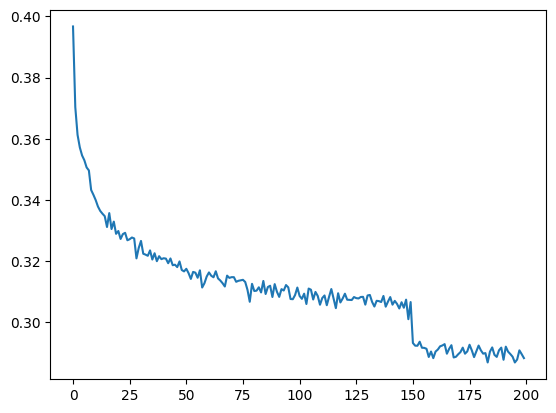

In [33]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [34]:
# put layers into eval model (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [35]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9196834564208984
val 2.0310118198394775


**performance log:**

* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.9196834564208984, val 2.0310118198394775

In [36]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all 0s

    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))  # (1, block_size)
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

rosa.
salider.
dannah.
alyssa.
nyden.
mackel.
devadt.
jayah.
grenclynn.
aziel.
veyona.
javery.
brall.
hitalee.
catai.
makztena.
esky.
gryen.
somas.
emdin.


### 3.3 implementing WaveNet

* the integer tensor of [4,8] example batch just contains the identities of those characters which are being fed in to predict the 9th character
* passing `Xb`, the integer tensor, through our embedding table creates an output of [4, 8, 10]. Our embedding table for each character creates a 10D vector that we are trying to learn, so what the embedding layer does here is it that it tries to pluck out th e embedding vector for each of the integers and organizes it all in a [4, 8, 10] tensor. So all of these integers are translated into 10D vectors inside the 3D tensor
* passing the same tensor through the Flatten layer we get an image tensor size [4, 80]. What it does is that for all of these 10D embeddings, all of these 8 character end up being stretched out into a long row and that looks kind of a like concatenation operation so by viewing the tensor differently we have a [4, 80], and inside the 80 it's all the 10D vectors just concatenating next to each other.
* in the linear layer, it takes 80 and creates 200 channels via matrix multiplication

**Let's look at the linear layer:**
* the linear layer takes the input `X` in the forward pass and matrix multiplies it with a weight and then optionally adds a bias, with the weight being 2D and the bias being 1D.
  * the input layer being matrix multiplied with the weight doesn't necessarily have to be 2D. The matrix multiplier in pytorch is quite powerful and everything will work fine even if you pass higher dimensional arrays -> matrix multiplication works only on the last dimension of the input tensor, and the rest of the dimensions before the last one (on the left) are left unchanged in the input tensor and are just treated as the batch dimension. So we can have all of those batch dimensions, and then in parallel over all those dimensions we're doing the matrix multiplication with the last dimension
  * this is quite convenient because we can use it in our network now because we have these eight characters coming in, and we don't want to flatten all of them into a larger 8D vector because we don't want to matrix mutliply 80 into a weight matrix immediately. Instead, we want to group them in pairs and then flatten them out and multiplied by the weight matrix, but all of the 4 groups of 2 we want to process in parallel. So it's kind of like a batch dimension that we can introduce, and then we can in parallel process all of these bigrams groups in the 4 batch dimensions of an individual examples and over the actual batch dimension of 4 examples in our example below.
* what we want now is:
  * we don't want 80 numbers to come in, rather we want only 2 characters to come in and those 2 characters should be fused so in other words we just want 20 numbers to come in -> so weight matrix turns from [80, 200] to [20, 200]
  * we don't want input matrix to be [4, 80] in the linear layer when fed in, we actually want these groups of 2 to feed in so we want it to be [4, 4, 20] -> these are the 4 groups of 2 and each one of them is 10D.
    * we want to change the flatten layer so that it doesn't output [4, 80] but it rather outputs a [4, 4, 20].
    * every 2 consecutive characters are packed in on the last dimension, with the first 4 being the first batch dimension, and the second 4 being the second batch dimension representing the 4 groups inside every one of the examples
    * we will have to change the linear layer in terms of how many inputs it expects (should expect 20 instead of 80), and we have to change our flatten layer so it doesn't fully flatten out the example rather it creates a 4x4x20 instead of a 4x80.
* to implement the above:
  * we have an input [4, 8, 10] which feeds into the flatten layer and currently the flatten layer just stretches it out. It takes the X and just it views it as whatever the batch dimension is.
  * we take the even parts and the odd parts and we're arranging them [4, 4, 10] right next to each other and concatenating them.
  * what else also works is that you can just use `view` again and request the right shape and in the end the vectors will end up arranging in exactly the same way we want to -> essentially we don't need to make an explicit call to concantenate etc. we can just take an input tensor to flatten and we can just view it in any way we want, in particular we don't want to stretch things out with -1. We want to actually create a 3D array and depending on how many vectors that are consective we want to fuse for e.g 2, then we can just ask the last dimension to be 20 and use a -1 in the 2nd dimension and pytorch will figure out how many groups it needs to pack in the 2nd dimension into this additional batch dimension. Let's implement this in `Flatten` (becomes `FlattenConsecutive`)! -> will diverge from the PyTorch one to make sure our API's are equal
* let's try to restructure `FlattenConsecutive` and implement it hierarchally
  * in particular we want to flatten not just the top block_size but just 2, and we want to process this with `Linear`. The number of inputs to this `Linear` will not be embed * block_size, it will now only be embed * 2 = 20.
  * Now the next linear layer should expect hidden * 2 and the last pieces of it should expect hidden * 2 again.
  * we now have 3 layers instead of the 4 layers in the paper, with a total receptive size (`block_size`) of 8 instead of 16 in the paper
  * our loss remains almost the same as before because:
    * we didn't torture the architecture a lot
    * there's a bunch of hyperparameters that can do our work in terms of how allocate our parameters to what layers
    * we have a bug inside the batchNorm 1D layer so let's fix that



In [37]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # batch of 4 with 8 characters as input
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[13,  1, 11, 25, 14, 12,  5,  9],
        [ 0,  0,  0,  0,  0, 12,  5, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 18]])

In [38]:
model.layers[0].out.shape # output of embedding layer

torch.Size([4, 8, 10])

In [39]:
model.layers[1].out.shape # output of Flatten layer

torch.Size([4, 80])

In [40]:
model.layers[2].out.shape # output of linear layer

torch.Size([4, 200])

In [41]:
# matrix multiplication works only on the last dimension of input tensor
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

 (1 2) (3 4) (5 6) (7 8) -> how we want them to be grouped

In [42]:
output_list = list(range(10))[::2]

In [43]:
e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10D vectors get concatenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim = 2) # first gives even characters, second gives us all the odd characters
explicit.shape

torch.Size([4, 4, 20])

In [44]:
(e.view(4, 4, 20) == explicit).all() # same

tensor(True)

In [45]:
# changing `Flatten` to `FlattenConsecutive`
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # flattens only n consecutive elements and inputs them into the last dimension

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # being explicit by not using -1
    if x.shape[1] == 1: # we want to return a 2D tensor
      x = x.squeeze(1) # squeeze out the singleton dimension 1
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [46]:
torch.manual_seed(42); # for reproducibility

In [47]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [48]:
# for layer in model.layers:
#   print(layer.__class__.__name__, ':', tuple(layer.out.shape))

expected output from the previous cell (not running for some reason):

<img src = "https://raw.githubusercontent.com/Raahim58/Neural-networks/main/images/wavenet%202.png" width = 300 height =300>

In [49]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.5996
  10000/ 200000: 2.2440
  20000/ 200000: 2.1171
  30000/ 200000: 2.1004
  40000/ 200000: 2.0080
  50000/ 200000: 2.4077
  60000/ 200000: 1.9603
  70000/ 200000: 1.9004
  80000/ 200000: 2.0219
  90000/ 200000: 1.9715
 100000/ 200000: 1.7206
 110000/ 200000: 2.3179
 120000/ 200000: 2.4396
 130000/ 200000: 2.0251
 140000/ 200000: 2.2399
 150000/ 200000: 1.5962
 160000/ 200000: 1.9752
 170000/ 200000: 2.1655
 180000/ 200000: 2.0415
 190000/ 200000: 1.8022


results here:


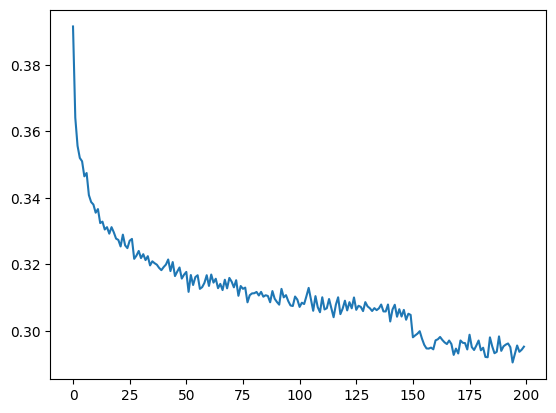

In [50]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [51]:
# put layers into eval model (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [52]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9443068504333496
val 2.0308573246002197


**performance log:**

* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.9197, val 2.0310
* flat -> hierarchical (22K params): train 1.9443, val 2.0309


### 3.4 Fixing the batchNorm1D bug

* currently BatchNorm1d is receiving an input of [32, 4, 68]. We wrote BatchNorm1d at the time with the assumption that X is 2D so it was [n, D] where n was the batch size so that's why we only reduced the mean and the variance over the 0th dimension but now X will become 3 dimensional.
* What's happening inside the BatchNorm1d layer right now is that it gives no errors yet because it broadcasts properly but the BatchNorm1d is not doing what we want it to do
* taking an example from our current BatchNorm1d, it takes only the first dimension hence the 32 examples and only broadcasts them. Basically what ends up happening is, when we also look at the running mean we realize we have an array of [1, 4, 68] means being maintained instead of just 68 means. This is telling us that the BatchNorm1d layer is working in parallel over 4 * 68 instead of just 68 channels. Basically, we are maintaining statistics for every one of these 4 positions individually and independtly, instead what we want to do is treat the 4 as a batch dimension just like 0th dimension. As far as BatchNorm1d is concerned, it doesn't want to average over 32 numbers, we want to average over 32 * 4 numbers for each of these 68 channels
* looking at PyTorch's `torch.mean()`, the `dim` can be int or tuple of ints, so we can reduce over multiple dimensions at the same time. Instead of just reducing over 0, we can pass in a tuple (0,1). The output will be the same, but now we reduce over (0,1) so we take the mean over both the 0 and the 1st dimension -> the correct things happens that we maintain the mean and variance only for the 68 channels and not for 32*4 dimensions.
* changing the implementation of BatchNorm1D to implement 2D or 3D inputs and perform accordingly
* we're only maintaing 68 means for our channels and we're treating both the 0th and 1st dimensions as a batch dimension which is what we want
* reason we slightly expect an improvement is we're not maintaining different means and variances that are only estimated using 32 numbers effectively, we are using them 32*4  so we have just a lot more numbers that go into any one estimate of the mean and variance and it allows things to be a bit more stable and less wiggly inside those estimates of those statistics

* we're diverging from `BatchNorm1D` of PyTorch
  * input to the layer can be [n,C] where n is the batch_size and C is the channels, or it can accept 3D inputs but it expects it to be [n, C, L] where L is the sequence length
  * C will always be the 1st dimension whereas we'll assume C is the last dimension and there are some number of batch dimensions before hand -> we expect [n, L, C] hence it's a deviation


In [53]:
# Before: what we're doing in BatchNorm1d right now
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim = True) # 1, 4, 68 -> over the first dimension
evar = e.var(0, keepdim = True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [54]:
# After
e = torch.randn(32, 4, 68)
emean = e.mean((0,1), keepdim = True) # 1, 1, 68 -> over the first dimension
evar = e.var((0,1), keepdim = True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [55]:
emean.shape

torch.Size([1, 1, 68])

In [56]:
model.layers[3].running_mean.shape # originally [1, 4, 68]

torch.Size([1, 4, 68])

In [62]:
# making it accept every dimension
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # flattens only n consecutive elements and inputs them into the last dimension

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # being explicit by not using -1
    if x.shape[1] == 1: # we want to return a 2D tensor
      x = x.squeeze(1) # squeeze out the singleton dimension 1
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [63]:
torch.manual_seed(42); # for reproducibility

In [64]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [65]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.6368
  10000/ 200000: 2.2370
  20000/ 200000: 2.1782
  30000/ 200000: 2.1241
  40000/ 200000: 2.0371
  50000/ 200000: 2.3543
  60000/ 200000: 1.9784
  70000/ 200000: 1.8721
  80000/ 200000: 1.8556
  90000/ 200000: 1.8684
 100000/ 200000: 1.6020
 110000/ 200000: 2.3549
 120000/ 200000: 2.4588
 130000/ 200000: 1.9693
 140000/ 200000: 2.2076
 150000/ 200000: 1.6611
 160000/ 200000: 1.9221
 170000/ 200000: 2.0669
 180000/ 200000: 1.9856
 190000/ 200000: 1.7908


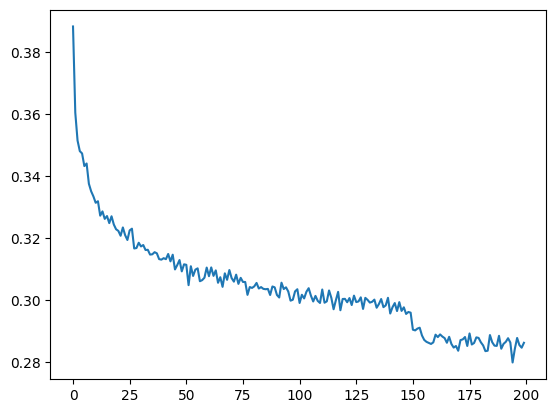

In [66]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [67]:
# put layers into eval model (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [68]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9123165607452393
val 2.022148609161377


**performance log:**

* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.9197, val 2.0310
* flat -> hierarchical (22K params): train 1.9443, val 2.0309
* fix bug in batchnorm: train 1.912, val 2.022


### 3.5 Scaling our WaveNet

* takes too long to train and we're kinda in the dark here with no experimental harness over our hyperparameters
* we're just looking at the training loss graph when we should be looking at the training and validation loss both

In [69]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # flattens only n consecutive elements and inputs them into the last dimension

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n) # being explicit by not using -1
    if x.shape[1] == 1: # we want to return a 2D tensor
      x = x.squeeze(1) # squeeze out the singleton dimension 1
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [70]:
torch.manual_seed(42); # for reproducibility

In [71]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ]

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [72]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.6596
  10000/ 200000: 2.0551
  20000/ 200000: 2.0342
  30000/ 200000: 2.6254
  40000/ 200000: 2.1558
  50000/ 200000: 1.7977
  60000/ 200000: 2.2949
  70000/ 200000: 1.8409
  80000/ 200000: 1.6752
  90000/ 200000: 2.1980
 100000/ 200000: 1.9085
 110000/ 200000: 2.0375
 120000/ 200000: 1.7249
 130000/ 200000: 1.8604
 140000/ 200000: 1.8156
 150000/ 200000: 1.9445
 160000/ 200000: 1.7933
 170000/ 200000: 1.6338
 180000/ 200000: 1.5115
 190000/ 200000: 1.8932


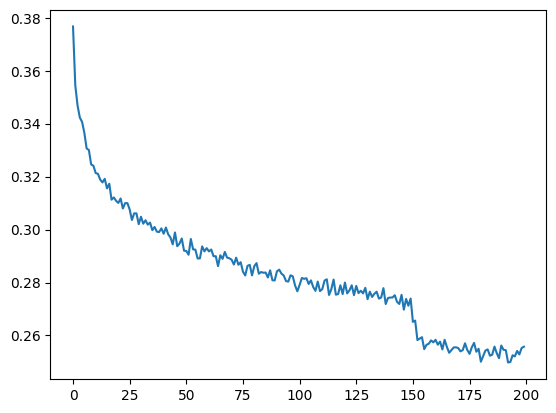

In [73]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [74]:
# put layers into eval model (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [75]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7686808109283447
val 1.9930692911148071


**performance log:**

* original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
* context: 3 -> 8 (22K params): train 1.9207, val 2.0325
* flat -> hierarchical (22K params): train 1.9098, val 2.0197
* fix bug in batchnorm: train 1.912, val 2.022
* scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993

In [76]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

aiyana.
yaius.
kenzlee.
shriya.
angelika.
christen.
kendley.
cander.
sophila.
breslyn.
saden.
cammyn.
ashua.
phoene.
tanni.
annie.
jeniyah.
glannie.
manaswa.
yeniel.


### 4. WaveNet with dilated causal convolutions

**convolution is a for loop, allows us to forward Linear layers efficiently over space**

* we didn't implement the exact forward pass for the WaveNet from the paper where we have a more complicated linear layer sort of. There are residual connections hence we didn't implement the forward pass and just implemented this structure
* how what we have done relates to convolutions described in the paper -> strictly for efficiency, doesn't change the model we've implemented
* we implement `Xtr[[7]]` to feed in the model to make it 2D with the batch dimension to not get an error when `Xtr[7]` is 1D
* we may want to forward all of the 8 characters at the same time. pre-allocating some memory and doing a for loop eight times and forwarding all those 8 will give us all the logits in all these different cases. Now for us implementing our model, it is 8 independent calls to our model but what convolutions allow you to, it allows you to slide the model efficiently over the input sequence. So, the for loop cannot be done outside in python but inside of kernels in Cuda so this for loop gets hidden into the covolution
* convoltion is hence a for loop applying a little linear filter over space of some input sequence, and in our case the space we're intersted in is 1D and we're interested in sliding thse filters over the input data
* what we've implemented is a single black structure and calculated a single output or a single example but what convolutions to do is that they allow you to take the black structure and slide it over the input sequence and calculate the orange outputs at the same time (in diagram), or for our example, all of the outputs at all the positions of diondre at the same time
  * the reason this is more efficient is because:
    1. the for loop is inside the Cuda kernels in the sliding so that makes it effcient
    2. there is a variable reuse -> a node and its value is used twice. In our naive way we would have to recalculate it but here we are allowed to reuse it.
* In the convolutional neural network you think of these linear layers that we have up above as filters, we take these linear filters and you slide them over the input sequence, and we calculate the first layer and the second layer, and then the third layer, and then the output layer of the sandwich, all efficiently using these convolutions.

In [79]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [80]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [81]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

## Summary

**1. Understanding the Neural Network Development Process:**

* A significant portion of time is spent on PyTorch documentation, reading through layers, and understanding the shapes of inputs and their functionality.
* Unfortunately, PyTorch documentation can be challenging. While accurate, it often lacks clarity and isn't very user-friendly.

**2. Handling Multidimensional Arrays:**

* A lot of time is spent managing and manipulating multidimensional arrays, dealing with different shapes like 2D, 3D, and 4D arrays, and ensuring that they fit into specific layers (e.g., SCL or NLC).
* This can involve complex operations, leading to messy code.

**3. Using Jupyter Notebooks for Development:**

* Often, neural network layers and implementations are developed in Jupyter notebooks to ensure that the shapes of arrays and tensors are correct.
* Once the code works in the notebook, it is copy-pasted into a repository for further development.
* The coding process typically involves both Jupyter notebooks and VS Code, with experimentation carried out in Jupyter notebooks and final code transferred to the repository in VS Code.

**4. Further Lecture Topics:**

* There are numerous potential topics for future lectures:
  1. Using causal convolutional layers.
  2. Decision functions and skip functions.
  3. Setting up the evaluation process for experimentation.

**5. Experimentation Process:**

* Running experiments involves setting up an evaluation process and kicking off numerous trials, checking training and validation losses to see what's working and what isn't.
* Experimentation is key to understanding neural network performance and pushing the development further.

**6. Exploration of Neural Network Architectures:**

* There is room for exploring recurrent neural networks (RNNs), long short-term memory (LSTM) networks, and transformers in future discussions.

**7. Potential for Improvement in Current Model:**

* There is still room for experimentation with the current neural network model to improve performance.
* Further tuning and optimizations, such as adjusting the number of embeddings or modifying initialization, could potentially lead to better results.